In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings("ignore")

# The following data are obtained from https://github.com/hwchase17/sportvu

data13 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2013.csv")
data13['season'] = ['2013' for _ in range(len(data13))]
data14 = pd.read_csv("https://raw.githubusercontent.com/hwchase17/sportvu/master/joined_shots_2014.csv")
data14['season'] = ['2014' for _ in range(len(data14))]


data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]

In [2]:
data.head()

,Unnamed: 0,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FGM,FINAL_MARGIN,GAME_CLOCK,GAME_ID,GAME_ID.1,...,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,season
0,0,"Turner, Evan",202323.0,1.9,17.0,0.0,10.0,8:09,21300165,21300165,...,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,6.0,-40.0,53.0,1.0,0.0,2013
1,1,"Turner, Evan",202323.0,3.2,0.0,1.0,10.0,9:10,21300165,21300165,...,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,182.0,195.0,1.0,1.0,2013
2,2,"Carter-Williams, Michael",203487.0,3.5,0.0,0.0,10.0,8:36,21300165,21300165,...,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26.0,159.0,206.0,1.0,0.0,2013
3,3,"Brown, Lorenzo",203485.0,3.6,19.0,0.0,10.0,0:23,21300165,21300165,...,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,27.0,-15.0,274.0,1.0,0.0,2013
4,0,"Cole, Norris",202708.0,3.7,0.0,1.0,-7.0,11:43,21300230,21300230,...,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,24.0,-149.0,198.0,1.0,1.0,2013


In [3]:
#Use for exploring other classifiers
import scipy as sp
from scipy import stats
import keras
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK']='True'

data = data[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG",'season']]
data = pd.get_dummies(data,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
data = data.dropna()
# here you can change the argument for training with a different season
data = data[data['season'] == '2013']

data = data.drop(['season'], axis = 1)

train_X = data.drop(['SHOT_MADE_FLAG'],axis = 1)
train_y = to_categorical(data['SHOT_MADE_FLAG'])

In [4]:
data.head()

,CLOSE_DEF_DIST,DRIBBLES,SHOT_DIST,SHOT_CLOCK,TOUCH_TIME,SHOT_MADE_FLAG,CLOSEST_DEFENDER_PLAYER_ID_708.0,CLOSEST_DEFENDER_PLAYER_ID_951.0,CLOSEST_DEFENDER_PLAYER_ID_959.0,CLOSEST_DEFENDER_PLAYER_ID_965.0,...,ACTION_TYPE_Running Slam Dunk Shot,ACTION_TYPE_Running Tip Shot,ACTION_TYPE_Slam Dunk Shot,ACTION_TYPE_Step Back Jump shot,ACTION_TYPE_Tip Shot,ACTION_TYPE_Turnaround Bank Hook Shot,ACTION_TYPE_Turnaround Bank shot,ACTION_TYPE_Turnaround Fadeaway shot,ACTION_TYPE_Turnaround Hook Shot,ACTION_TYPE_Turnaround Jump Shot
0,1.9,17.0,7.7,9.8,13.5,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3.2,0.0,23.5,8.1,1.4,1.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3.5,0.0,25.7,11.0,1.3,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3.6,19.0,24.7,9.0,14.5,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,2.4,5.0,28.4,2.6,4.5,0.0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
# Lightgbm
!pip install lightgbm
import lightgbm as lgb

#Train model13
data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]

data = data[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG",'season']]
data = pd.get_dummies(data,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
data = data.dropna()
# here you can change the argument for training with a different season
data = data[data['season'] == '2013']

data = data.drop(['season'], axis = 1)

train_X = data.drop(['SHOT_MADE_FLAG'],axis = 1)
train_y = data['SHOT_MADE_FLAG']

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 71,
    'learning_rate': 0.025,
    'min_data_in_leaf': 20,
    'max_depth': 40,
    'feature_fraction': 0.65,
    'verbose': -1,
    'n_estimators': 200

}

# Create LightGBM Dataset objects
lgb_train13 = lgb.Dataset(train_X, train_y)

# Train the LightGBM model
lgb_model13 = lgb.train(params, lgb_train13, num_boost_round=100)

#Train model14
data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]

data = data[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG",'season']]
data = pd.get_dummies(data,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
data = data.dropna()
# here you can change the argument for training with a different season
data = data[data['season'] == '2014']

data = data.drop(['season'], axis = 1)

train_X = data.drop(['SHOT_MADE_FLAG'],axis = 1)
train_y = data['SHOT_MADE_FLAG']

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 71,
    'learning_rate': 0.025,
    'min_data_in_leaf': 20,
    'max_depth': 40,
    'feature_fraction': 0.65,
    'verbose': -1,
    'n_estimators': 200
}

# Create LightGBM Dataset objects
lgb_train14 = lgb.Dataset(train_X, train_y)

# Train the LightGBM model
lgb_model14 = lgb.train(params, lgb_train14, num_boost_round=100)


In [6]:
data = pd.concat([data13,data14],ignore_index=True)
data = data[data["TOUCH_TIME"] >= 0]
test = data
test = test[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG","season"]]
test = pd.get_dummies(test,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
test = test.dropna()

tmp = test[test["season"] == '2013']
#predictions13 =  model14.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1))
predictions13 =  lgb_model14.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1),num_iteration=lgb_model14.best_iteration)
tmp = test[test["season"] == '2014']
#predictions14 =  model13.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1))
predictions14 =  lgb_model13.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1),num_iteration=lgb_model13.best_iteration)

test = data
test = test.dropna()

test['prob'] = list(predictions13[:])+list(predictions14[:])

Test set accuracy:  0.6566295374488283
The model's brier score is:  0.21470430377930633
The climatology's brier score is:  0.24793219794785007


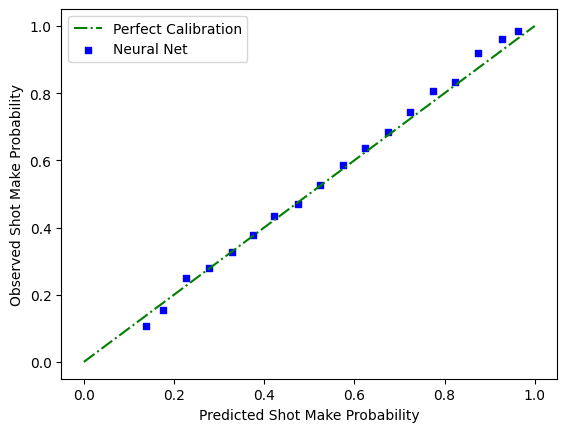

In [7]:
# evaluate the error on the data that will not be used for the hot hand

SHOT_THRES = 1000


predictions = []
shot_outcome = []

#test1 = test[test["season"] == '2014']

#shots_pl = test.groupby('PLAYER_ID')
shots_pl = test.groupby('PLAYER_ID')

players = []

#for p in test1['PLAYER_ID'].unique():
for p in test['PLAYER_ID'].unique():
    if len(shots_pl.get_group(p)) > SHOT_THRES:
        players.append(p)

for p in players:
    player_df = shots_pl.get_group(p)
    player_df_games = player_df.groupby("GAME_ID")
    # find the games that we have full data for the player
    games_p = []
    good_shots = 0
    for g in player_df['GAME_ID'].unique():
        tmp = player_df_games.get_group(g)
        if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
            games_p.append(g)
            good_shots += len(tmp.SHOT_NUMBER)

    for g in games_p:
        tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
        tmp_prob = list(player_df_games.get_group(g)['prob'])
        for i in range(len(list(tmp))-1):
            if list(tmp)[i] == 1:
                predictions.append(list(tmp_prob)[i+1])
                shot_outcome.append(list(tmp)[i+1])
accuracy = np.sum(np.round(predictions) == shot_outcome)/len(shot_outcome)

print("Test set accuracy: ",np.sum(np.round(predictions) == shot_outcome)/len(shot_outcome))

# brier score

print("The model's brier score is: ",  brier_score_loss(shot_outcome,predictions))
print("The climatology's brier score is: ", brier_score_loss(shot_outcome,(sum(shot_outcome)/len(shot_outcome))*np.ones(len(shot_outcome))))
observed, predicted = calibration_curve(shot_outcome, predictions, n_bins = 20)

fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.linspace(0,1,10000)
y = x
ax1.plot(x,y,'-.g',label="Perfect Calibration")

ax1.scatter(predicted,observed,s=20, c='b', marker="s", label = "Neural Net")


plt.xlabel("Predicted Shot Make Probability")
plt.ylabel("Observed Shot Make Probability")
plt.legend(loc='upper left');
plt.show()

Overall test set accuracy: 0.6566295374488283


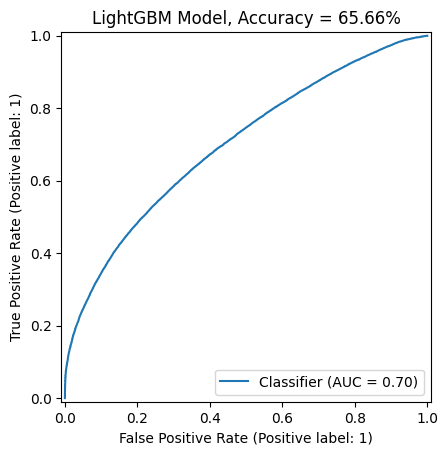

In [9]:
y_prob = predictions
y_pred = np.round(predictions)
yt = shot_outcome

from sklearn.metrics import accuracy_score

# Calculate overall accuracy
overall_accuracy = accuracy_score(yt, y_pred)
print(f"Overall test set accuracy: {overall_accuracy}")

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(yt, y_prob)
plt.title("LightGBM Model, Accuracy = 65.66%")
plt.show()

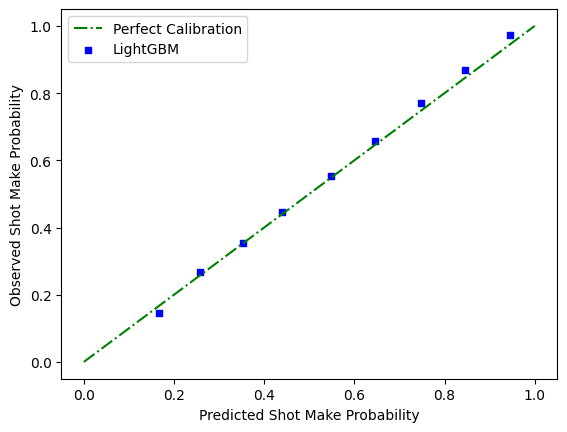

In [ ]:
observed, predicted = calibration_curve(shot_outcome, predictions, n_bins = 10)

fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.linspace(0,1,10000)
y = x
ax1.plot(x,y,'-.g',label="Perfect Calibration")

ax1.scatter(predicted,observed,s=20, c='b', marker="s", label = "LightGBM")


plt.xlabel("Predicted Shot Make Probability")
plt.ylabel("Observed Shot Make Probability")
plt.legend(loc='upper left');
plt.show()

In [ ]:
!pip install wandb -Uq
import wandb
import random
wandb.login()

True

In [ ]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'accuracy',
    'goal': 'maximize'
    }

sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'learning_rate': {
        'values': [0.025, 0.05, 0.075, 0.1]
        },
    'num_leaves': {
        'values': [31, 41, 51, 61, 71, 81]
        },
    'min_data_in_leaf': {
        'values': [10,20,30,40]
        },
    'max_depth': {
        'values': [20,30,40,50]
        },
    'feature_fraction': {
        'values': [0.55, 0.65, 0.75, 0.85]
        },
    'n_estimators': {
          'values': [100, 125, 150, 200]
        },
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'maximize', 'name': 'accuracy'},
 'parameters': {'feature_fraction': {'values': [0.55, 0.65, 0.75, 0.85]},
                'learning_rate': {'values': [0.025, 0.05, 0.075, 0.1]},
                'max_depth': {'values': [20, 30, 40, 50]},
                'min_data_in_leaf': {'values': [10, 20, 30, 40]},
                'n_estimators': {'values': [100, 125, 150, 200]},
                'num_leaves': {'values': [31, 41, 51, 61, 71, 81]}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Hot Hand LightGBM")

Create sweep with ID: pjtzbsyi
Sweep URL: https://wandb.ai/ljw7736-new-york-university/Hot%20Hand%20LightGBM/sweeps/pjtzbsyi


In [ ]:
!pip install lightgbm
import lightgbm as lgb

config = dict(
  num_leaves = 31,
  min_data_in_leaf = 20,
  max_depth = 20,
  learning_rate = 0.05,
  feature_fraction =  0.75,
  n_estimators = 100)


def train_wandb(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        print("Starting")

        num_leaves = config.num_leaves
        learning_rate = config.learning_rate
        feature_fraction = config.feature_fraction
        n_estimators = config.n_estimators
        min_data_in_leaf = config.min_data_in_leaf
        max_depth = config.max_depth

        params = {}

        params['objective'] = 'binary'
        params['metric'] = 'binary_logloss'
        params['verbose'] = -1
        params['boosting_type'] = 'gbdt'

        params['num_leaves'] = num_leaves
        params['learning_rate'] = learning_rate
        params['feature_fraction'] = feature_fraction
        params['n_estimators'] = n_estimators
        params['min_data_in_leaf'] = config.min_data_in_leaf
        params['max_depth'] = config.max_depth

        #Train model13
        data = pd.concat([data13,data14],ignore_index=True)
        data = data[data["TOUCH_TIME"] >= 0]

        data = data[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG",'season']]
        data = pd.get_dummies(data,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
        data = data.dropna()
        # here you can change the argument for training with a different season
        data = data[data['season'] == '2013']

        data = data.drop(['season'], axis = 1)

        train_X = data.drop(['SHOT_MADE_FLAG'],axis = 1)
        train_y = data['SHOT_MADE_FLAG']

        # Create LightGBM Dataset objects
        lgb_train13 = lgb.Dataset(train_X, train_y)

        # Train the LightGBM model
        lgb_model13 = lgb.train(params, lgb_train13, num_boost_round=100)

        #Train model14
        data = pd.concat([data13,data14],ignore_index=True)
        data = data[data["TOUCH_TIME"] >= 0]

        data = data[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG",'season']]
        data = pd.get_dummies(data,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
        data = data.dropna()
        # here you can change the argument for training with a different season
        data = data[data['season'] == '2014']

        data = data.drop(['season'], axis = 1)

        train_X = data.drop(['SHOT_MADE_FLAG'],axis = 1)
        train_y = data['SHOT_MADE_FLAG']

        # Create LightGBM Dataset objects
        lgb_train14 = lgb.Dataset(train_X, train_y)

        # Train the LightGBM model
        lgb_model14 = lgb.train(params, lgb_train14, num_boost_round=100)

        #Testing
        data = pd.concat([data13,data14],ignore_index=True)
        data = data[data["TOUCH_TIME"] >= 0]
        test = data
        test = test[["CLOSE_DEF_DIST","DRIBBLES","SHOT_DIST","SHOT_CLOCK","TOUCH_TIME","CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE","SHOT_MADE_FLAG","season"]]
        test = pd.get_dummies(test,columns=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"],prefix=["CLOSEST_DEFENDER_PLAYER_ID","PLAYER_ID","ACTION_TYPE"])
        test = test.dropna()

        tmp = test[test["season"] == '2013']
        #predictions13 =  model14.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1))
        predictions13 =  lgb_model14.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1),num_iteration=lgb_model14.best_iteration)
        tmp = test[test["season"] == '2014']
        #predictions14 =  model13.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1))
        predictions14 =  lgb_model13.predict(tmp.drop(['season','SHOT_MADE_FLAG'],axis = 1),num_iteration=lgb_model13.best_iteration)

        test = data
        test = test.dropna()

        test['prob'] = list(predictions13[:])+list(predictions14[:])

        #Calculate accuracy
        SHOT_THRES = 1000
        predictions = []
        shot_outcome = []

        #test1 = test[test["season"] == '2014']

        #shots_pl = test.groupby('PLAYER_ID')
        shots_pl = test.groupby('PLAYER_ID')

        players = []

        #for p in test1['PLAYER_ID'].unique():
        for p in test['PLAYER_ID'].unique():
            if len(shots_pl.get_group(p)) > SHOT_THRES:
                players.append(p)

        for p in players:
            player_df = shots_pl.get_group(p)
            player_df_games = player_df.groupby("GAME_ID")
            # find the games that we have full data for the player
            games_p = []
            good_shots = 0
            for g in player_df['GAME_ID'].unique():
                tmp = player_df_games.get_group(g)
                if len(tmp.SHOT_NUMBER)-max(tmp.SHOT_NUMBER)==0:
                    games_p.append(g)
                    good_shots += len(tmp.SHOT_NUMBER)

            for g in games_p:
                tmp = list(player_df_games.get_group(g)['SHOT_MADE_FLAG'])
                tmp_prob = list(player_df_games.get_group(g)['prob'])
                for i in range(len(list(tmp))-1):
                    if list(tmp)[i] == 1:
                        predictions.append(list(tmp_prob)[i+1])
                        shot_outcome.append(list(tmp)[i+1])
        accuracy = np.sum(np.round(predictions) == shot_outcome)/len(shot_outcome)

        wandb.log({"accuracy": accuracy})

In [ ]:
wandb.agent(sweep_id, train_wandb, count=20)

wandb: Agent Starting Run: vwtiyee7 with config:
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 20
wandb: 	min_data_in_leaf: 20
wandb: 	n_estimators: 150
wandb: 	num_leaves: 51


Starting


accuracy,▁
accuracy,0.65517


wandb: Agent Starting Run: ujenka1f with config:
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 40
wandb: 	min_data_in_leaf: 20
wandb: 	n_estimators: 150
wandb: 	num_leaves: 31


Starting


accuracy,▁
accuracy,0.65564


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bpfvzfgy with config:
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 40
wandb: 	min_data_in_leaf: 30
wandb: 	n_estimators: 150
wandb: 	num_leaves: 51


Starting


accuracy,▁
accuracy,0.65547


wandb: Agent Starting Run: kfagivb7 with config:
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 40
wandb: 	min_data_in_leaf: 30
wandb: 	n_estimators: 150
wandb: 	num_leaves: 81


Starting


accuracy,▁
accuracy,0.65629


wandb: Agent Starting Run: 92wgx171 with config:
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 40
wandb: 	min_data_in_leaf: 20
wandb: 	n_estimators: 200
wandb: 	num_leaves: 71


Starting


accuracy,▁
accuracy,0.65663


wandb: Agent Starting Run: 3zqi0t62 with config:
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 30
wandb: 	min_data_in_leaf: 20
wandb: 	n_estimators: 125
wandb: 	num_leaves: 41


Starting


accuracy,▁
accuracy,0.65636


wandb: Agent Starting Run: s4eywwp9 with config:
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 40
wandb: 	min_data_in_leaf: 40
wandb: 	n_estimators: 125
wandb: 	num_leaves: 61


Starting


accuracy,▁
accuracy,0.65534


wandb: Agent Starting Run: 9jamq0cy with config:
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 50
wandb: 	min_data_in_leaf: 10
wandb: 	n_estimators: 150
wandb: 	num_leaves: 51


Starting


accuracy,▁
accuracy,0.65531


wandb: Agent Starting Run: wk6xz4px with config:
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 20
wandb: 	min_data_in_leaf: 40
wandb: 	n_estimators: 125
wandb: 	num_leaves: 41


Starting


accuracy,▁
accuracy,0.65511


wandb: Agent Starting Run: tnyei5dk with config:
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 20
wandb: 	min_data_in_leaf: 30
wandb: 	n_estimators: 125
wandb: 	num_leaves: 51


Starting


accuracy,▁
accuracy,0.65592


wandb: Agent Starting Run: 0fyn8wj2 with config:
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 50
wandb: 	min_data_in_leaf: 30
wandb: 	n_estimators: 150
wandb: 	num_leaves: 31


Starting


accuracy,▁
accuracy,0.65551


wandb: Agent Starting Run: zs460x7w with config:
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 20
wandb: 	min_data_in_leaf: 30
wandb: 	n_estimators: 100
wandb: 	num_leaves: 71


Starting


accuracy,▁
accuracy,0.65591


wandb: Agent Starting Run: d40paws8 with config:
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 40
wandb: 	min_data_in_leaf: 30
wandb: 	n_estimators: 150
wandb: 	num_leaves: 41


Starting


accuracy,▁
accuracy,0.65618


wandb: Agent Starting Run: 5rdikp6c with config:
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 30
wandb: 	min_data_in_leaf: 20
wandb: 	n_estimators: 100
wandb: 	num_leaves: 81


Starting


accuracy,▁
accuracy,0.65581


wandb: Agent Starting Run: xfnws85t with config:
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 40
wandb: 	min_data_in_leaf: 10
wandb: 	n_estimators: 125
wandb: 	num_leaves: 81


Starting


accuracy,▁
accuracy,0.6555


wandb: Agent Starting Run: 69sljl11 with config:
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 30
wandb: 	min_data_in_leaf: 40
wandb: 	n_estimators: 150
wandb: 	num_leaves: 41


Starting


accuracy,▁
accuracy,0.65498


wandb: Agent Starting Run: ejc8w73y with config:
wandb: 	feature_fraction: 0.55
wandb: 	learning_rate: 0.05
wandb: 	max_depth: 50
wandb: 	min_data_in_leaf: 30
wandb: 	n_estimators: 100
wandb: 	num_leaves: 31


Starting


accuracy,▁
accuracy,0.65539


wandb: Agent Starting Run: tt9k35m0 with config:
wandb: 	feature_fraction: 0.65
wandb: 	learning_rate: 0.025
wandb: 	max_depth: 20
wandb: 	min_data_in_leaf: 10
wandb: 	n_estimators: 150
wandb: 	num_leaves: 71


Starting


accuracy,▁
accuracy,0.65575


wandb: Agent Starting Run: m5e7cup6 with config:
wandb: 	feature_fraction: 0.75
wandb: 	learning_rate: 0.1
wandb: 	max_depth: 30
wandb: 	min_data_in_leaf: 40
wandb: 	n_estimators: 125
wandb: 	num_leaves: 71


Starting


accuracy,▁
accuracy,0.65602


wandb: Agent Starting Run: e34146yn with config:
wandb: 	feature_fraction: 0.85
wandb: 	learning_rate: 0.075
wandb: 	max_depth: 20
wandb: 	min_data_in_leaf: 40
wandb: 	n_estimators: 200
wandb: 	num_leaves: 31


Starting


accuracy,▁
accuracy,0.65556
